
# **Transformações de perspectiva**

#### **Iremos aprender:**
1. Usar as funções do OpenCV getPerspectiveTransform
2. Utilizar a função findContours para pegar as pontas e automatizar a transformação de perspectiva


In [3]:
# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()
    
# Download and unzip our images 
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/images.zip

!unzip -qq images.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


(960, 720, 3)


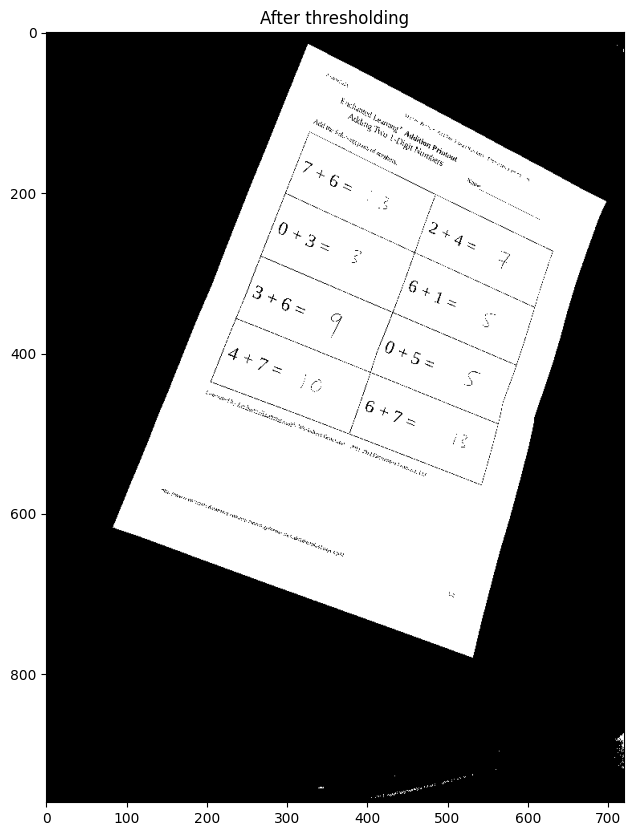

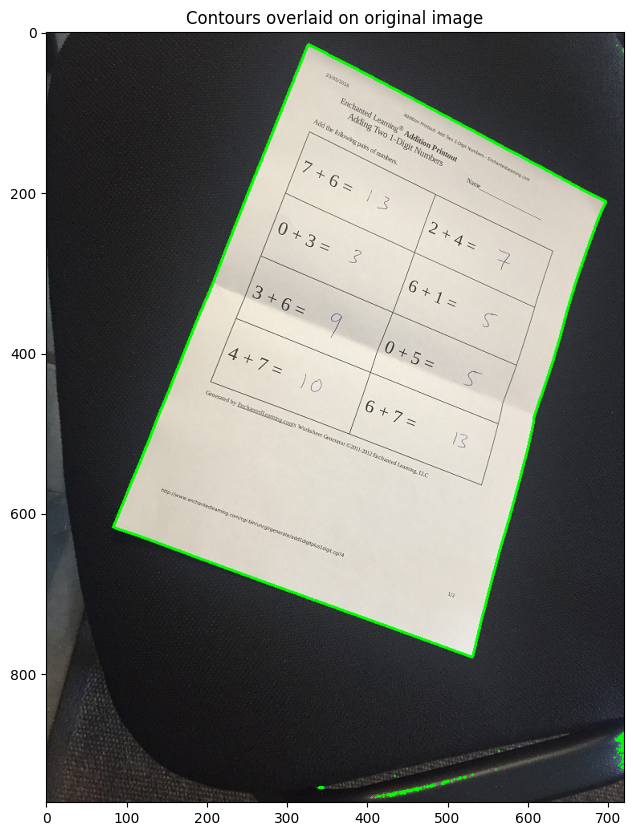

Number of Contours found = 54


In [4]:
image = cv2.imread('images/scan.jpg')

print(image.shape)

# jogar para escala de cinza
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, th2 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow('After thresholding', th2)

# Use uma cópia da sua imagem, por exemplo. edged.copy(), já que findContours altera a imagem
contours, hierarchy = cv2.findContours(th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Desenhando os contornos, sobrescrevendo a imagem original
# Use '-1' as the 3rd parameter to draw all
cv2.drawContours(image, contours, -1, (0,255,0), thickness = 2)
imshow('Contours overlaid on original image', image)

print("Number of Contours found = " + str(len(contours)))

### **Aproxime nosso contorno acima em apenas 4 pontos usando approxPolyDP**

In [5]:
# ordernar os contornos do maior para o menor, pela área

sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Aplicando a aproximação.
for cnt in sorted_contours:
	# approximate the contour
	perimeter = cv2.arcLength(cnt, True)
	approx = cv2.approxPolyDP(cnt, 0.05 * perimeter, True)
 
	if len(approx) == 4:
		break

# Nossas coordenadas x, y dos quatro cantos dos contornos
print("Our 4 corner points are:")
print(approx)



Our 4 corner points are:
[[[326  15]]

 [[ 83 617]]

 [[531 779]]

 [[697 211]]]


### **Usando getPerspectiveTransform e warpPerspective para criar nossa visão de cima para baixo**

Note: We mannauly matched the order of the points

Função getPerspectiveTransform:
A transformação de perspectiva ajusta a posição dos pixels para que as proporções ou ângulos de uma área na imagem se alinhem aos pontos de destino. Isso é comumente usado para corrigir a distorção de perspectiva (ex.: capturar uma tabela ou documento em um ângulo inclinado) ou Transformar uma região da imagem em uma área plana.

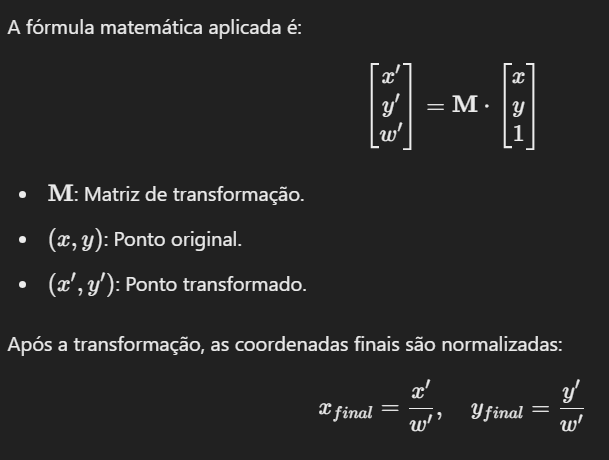


O w na fórmula da transformação de perspectiva é o fator de normalização que permite converter as coordenadas projetadas em uma forma utilizável para a tela (ou imagem). Ele é usado no contexto da álgebra linear e geometria projetiva para trabalhar com coordenadas homogêneas.
Em geometria projetiva, um ponto  (𝑥,𝑦)no espaço 2D é representado como (x,y,1) em coordenadas homogêneas. Após a aplicação da matriz de transformação, as coordenadas resultantes (x′,y ′,w ′) ainda estão em forma homogênea. 


Parâmetros:

- src - Coordenadas dos pontos de origem na imagem original (Deve conter quatro pontos, é um quadrilátero)
- dst - Coordenadas dos pontos de destino na imagem de saída


retorno: uma matriz 3×3, que é a matriz de transformação de perspectiva


[[[326.  15.]]

 [[ 83. 617.]]

 [[531. 779.]]

 [[697. 211.]]]
(800, 500, 3)


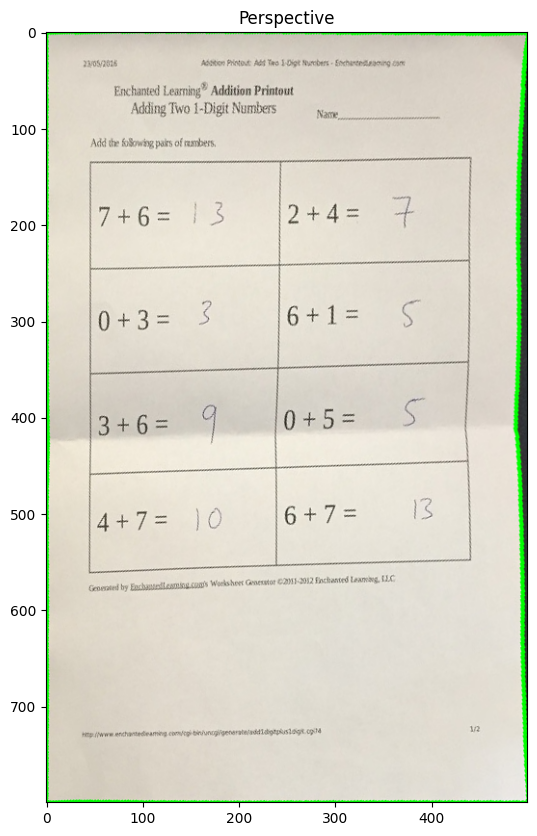

In [6]:
# Os valores são:
# canto superior esquerdo, canto inferior esquerdo, canto inferior direito, canto superior direito
inputPts = np.float32(approx)

print(inputPts)

outputPts = np.float32([[0,0],
                       [0,800],
                       [500,800],
                       [500,0]])

# Transformando a imagem, conforme a matriz especificada.
M = cv2.getPerspectiveTransform(inputPts,outputPts)

# Com a matriz de transformação, iremos aplicar.

#parâmetros:
# src: imagem colorida ou cinza
# M: Matriz de transformação, Obtida com cv2.getPerspectiveTransform ou cv2.findHomography.
# dsize: Dimensão da imagem de saída (largura, altura)
# dst (opcional): Local onde a imagem de saída será armazenada. 
#   Se não for fornecido, a função retornará a imagem transformada
final = cv2.warpPerspective(image, M, (500,800))

print(final.shape)

imshow("Perspective", final)

### **Excercise**

1. Ordene os pontos em ```aprox``` ordenando do canto superior esquerdo no sentido horário 
(ou seja, canto superior esquerdo, canto superior direito, canto inferior esquerdo, canto inferior direito)

2. Obtenha a proporção inicial do contorno e ajuste o Warp final para produzir nessa proporção e orientação


Lembre-se:
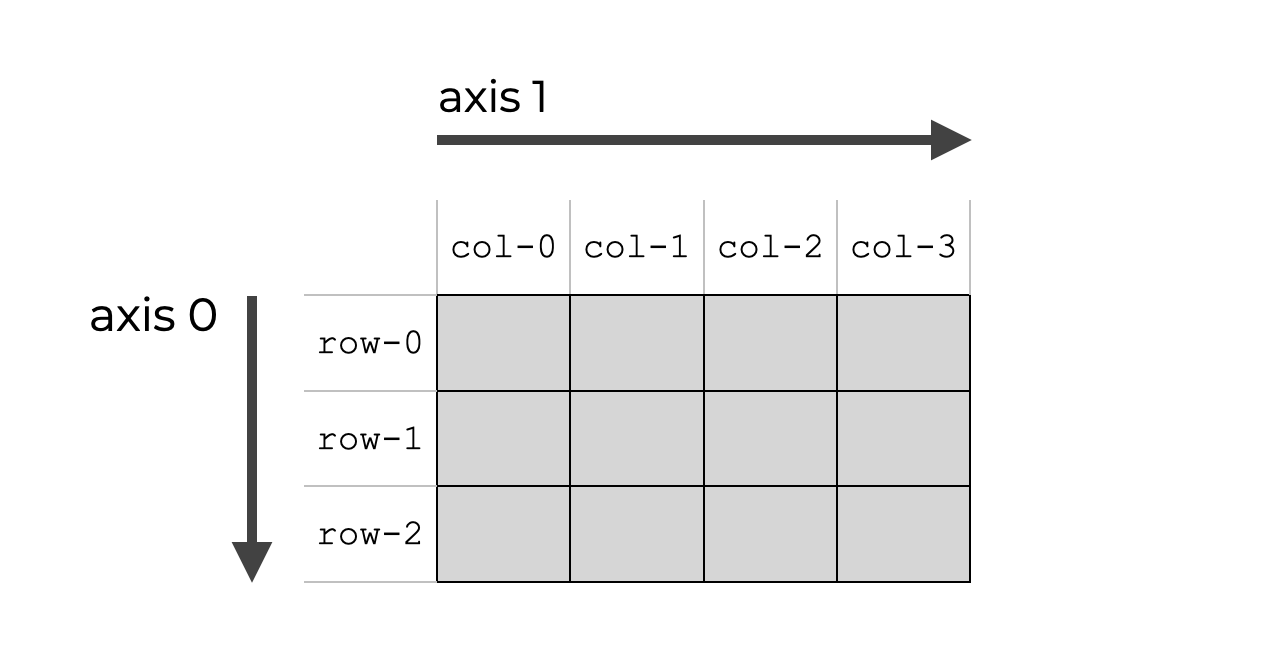

RESOLUÇÃO: UTILIZE COORDENADAS POLARES

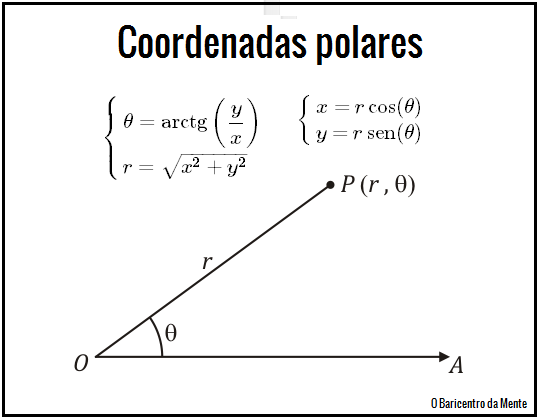

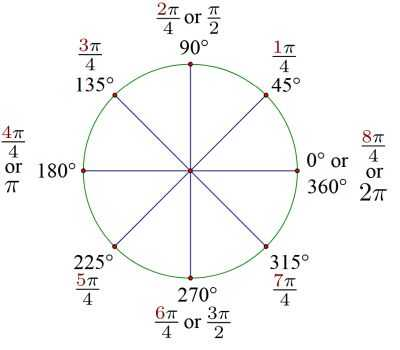

- Calcule o centro (centroide): O centroide é a média das coordenadas x e
y. Ele será usado como referência para determinar a posição relativa de cada ponto. 
- Calcule os ângulos dos pontos em relação ao centroide: Use a função arctan2 para determinar o ângulo entre cada ponto e o centroide
- Ordene os ângulos em ordem crescente para obter os pontos no sentido horário.

A função np.arctan2(y, x) calcula o ângulo em radianos entre o ponto (x,y) e o eixo x, considerando o sinal de ambos os valores para determinar o quadrante correto. Diferente de arctan(y/x), ela retorna o ângulo no intervalo [−π,π], garantindo precisão em todas as direções do plano cartesiano.

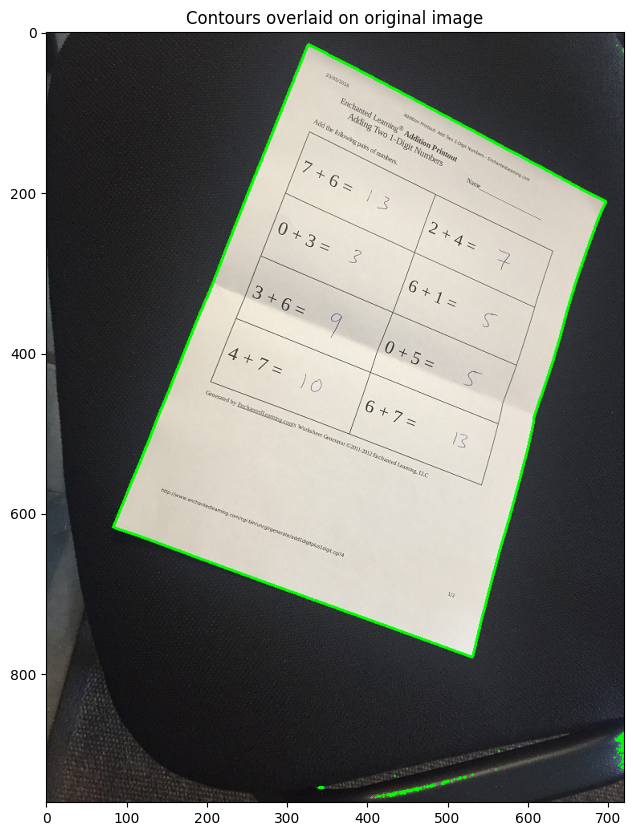

Our 4 corner points are:
Original 
[[[326  15]]

 [[ 83 617]]

 [[531 779]]

 [[697 211]]] 
 (4, 1, 2)
[-1.78084011  2.56643044  1.25568685 -0.59439102]
Pontos organizados no sentido horário:
[[[ 83 617]]

 [[531 779]]

 [[697 211]]

 [[326  15]]]
(800, 500, 3)


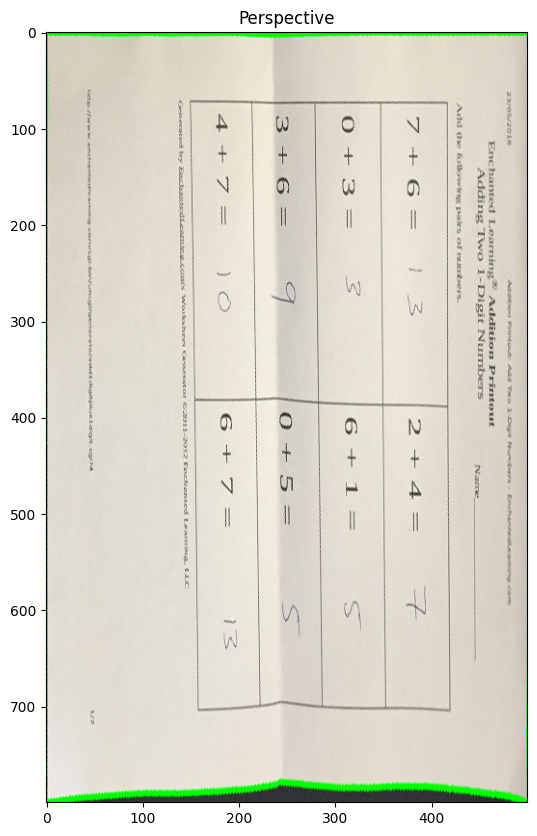

In [ ]:


sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Aplicando a aproximação.
for cnt in sorted_contours:
	# approximate the contour
	perimeter = cv2.arcLength(cnt, True)
	approx = cv2.approxPolyDP(cnt, 0.05 * perimeter, True)
 
	if len(approx) == 4:
		break

imshow('Contours overlaid on original image', image)
# Nossas coordenadas x, y dos quatro cantos dos contornos
print("Our 4 corner points are:")
print(F"Original \n{approx} \n {approx.shape}")



def sort_points_clockwise(points):
    # Transformar para o formato (4, 2)
    points = points.reshape(4, 2)
    
    # Calcular o centroide
    center = np.mean(points, axis=0)
    
    # Calcular os ângulos de cada ponto em relação ao centro
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    print(angles)
    # Ordenar os pontos no sentido horário
    sorted_indices = np.argsort(-angles)  # Ordem decrescente para sentido horário
    sorted_points = points[sorted_indices]
    
    # Retornar no formato original (4, 1, 2)
    return sorted_points.reshape(4, 1, 2)

sorted_points = sort_points_clockwise(approx)
print("Pontos organizados no sentido horário:")
print(sorted_points)

inputPts = np.float32(sorted_points)

outputPts = np.float32([[0,0],
                       [0,800],
                       [500,800],
                       [500,0]])

# Transformando a imagem, conforme a matriz especificada.
M = cv2.getPerspectiveTransform(inputPts,outputPts)

# Com a matriz de transformação, iremos aplicar.

#parâmetros:
# src: imagem colorida ou cinza
# M: Matriz de transformação, Obtida com cv2.getPerspectiveTransform ou cv2.findHomography.
# dsize: Dimensão da imagem de saída (largura, altura)
# dst (opcional): Local onde a imagem de saída será armazenada. 
#   Se não for fornecido, a função retornará a imagem transformada
final = cv2.warpPerspective(image, M, (500,800))

print(final.shape)

imshow("Perspective", final)